

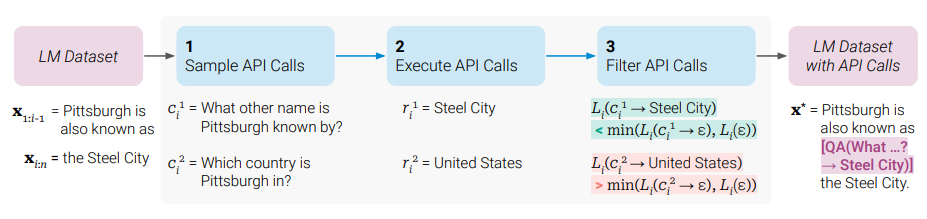




### Toolformer is  model trained to decide when to call an API, which API call to call, what arguments to pass and how to best incoparate the results into future token prediction.

The Figure above illustrate the key approach in creatsing the dataset for finening the model (M)

1. Given input text (x) we first sample position (i) which is a potential position to make an API call 

    Given  P(x) (Prompt) and x[:i], what is the porbability of making an making call i position
      
       pi = M.probability(<API>, "P(x)", x[:i])
    
2. At each position (i) we sample correposponding API call candidates c1...ck. 


3. The API are executed to get their response:

    ```
     x = Pittsburgh is also known as the Steel City
     x1:i-1 = Pittsburgh is also known as
     xi:n = the Steel City

     at i position we execute the API call given x1:i-1
     r (API results) = Steel Ciy
    ```

4. Filter API call which do not reduce the over the next tokens

     ```
     let L(z) denote weighte cross entropy loss of M
     let e denote empty sequence , c (API name)
, and r (API result)

     Two different instantiations of L(z) are computed

          L+ = L(e(c, r)) # Loss over making an API call and getting response
          L- = min(L(e), L(e(c,e))) #Minimum Loss of the model between  (not making an API ) and (proving the name of the API call with no results)

      Given a Threshhold denoted as T, we want to filter API call that satify the below condition
        
          (L- - L+ > T)

    ```
 5. Model Finetuning: Take C* (Dataset augmented with API and finetune M)


   

     

In [12]:
import numpy as np


# Sample API call
def sample_api_calls(input, model, position_threshold, loss_threshold,  topK=5):
  n = len(input)
  positions = [] # positions to call an API calls
  api_calls = [] # API calls generated by M
  responses = [] # reponses of the API call
  filtered_api_calls = [] # filtered api calls


  augmented_dataset = [] # C*


  # 1. Sampling API calls
  for i in range(n):
    pi = model.probability("<API>", "P(x)", x[:i])
    if pi > position_threshold:
      positions.append(i)

   # if the are position: we select TopK postions
  if len(positions) > topK:
    positions = positions[:topK]

  # 2. Generate API call candidates for position i
  for i in positions:
    # Assuming we only need a one candidate for position i
    prefix = ["P(x)"] + input[:i] + ["<API>"]
   
    # generate what suppose to go inside an API call
    # eg <API>Calculator(What is the square root of 64)</API>
    api_call = model.sample(prefix, "</API>")

    api_calls.append(api_call)

  # 3. Execute the API calls
  for api_call in api_calls:
    response = execute_api_call(api_call)
    responses.append(response)

  # 4. Filtering API Calls
  removed_i = set()
  for i, api_call in enumerate(api_call):
    position = positions[i]
    response = responses[i]
    loss_plus_i = weighted_loss(model, input[:position], api_call, response)
    loss_minus_i = min(weighted_loss(model, input[:position], "", ""),
                           weighted_loss(model, input[:position], api_call, ""))
    
    # threshold to keep api
    if loss_minus_i - loss_plus_i >= loss_threshold:
      filtered_api_calls.append(api_call)
    else:
      removed_i.add(i)


    # Finetuning
    for i in positions:
      if i not in removed_i:
        augmented_x = input[:i] + [api_call[i], responses[i]] + input[i:]
        augmented_dataset.append(augmented_x)

    # finetune M on Augmented Dataset
    augmented_dataset(augmented_dataset)



def weighted_loss(M, x, api_call, response):
  """
  Compute the weighted cross entropy loss for M

  """
  pass

def execute_api_call(api_call):
  """

  check if the api call is a calculator, retrieval, etc
  and return response given input

  """
  pass

def finetuneM(augmented_dataset):
  pass